In [1]:
!pip install segmentation-models-pytorch
!pip install albumentations
!pip install --upgrade efficientnet-pytorch
!pip install openpyxl
!pip install pandas
!pip install matplotlib
!pip install -U albumentations[imgaug]

In [2]:
import numpy as np                                                      # 파이썬 수치 계산을 위한 라이브러리
import pandas as pd                                                     # 파이썬 데이터 분석을 위한 라이브러리
import os                                                               # 폴더 검색 등 os에 관련된 명령어 사용을 위한 라이브러리                                                       
import matplotlib.pyplot as plt                                         # 데이터 시각화를 위한 라이브러리
import cv2                                                              # OpenCV 라브러리 사용을 위한 라이브러리
import re                                                               # 정규 표현식을 사용해 문자열 처리를 위한 라이브러리

import torch                                                            # 딥러닝 프레임워크인 pytorch 라이브러리
from torch import LongTensor                                            # pytorch의 Tensor class중 하나인 LongTensor를 불러옴
from torch.utils.data import DataLoader, Dataset                        # 데이터를 불러오는 class인 DataLoader와 데이터셋 구성을 위한 Dataset class를 불러옴 



import segmentation_models_pytorch as SM                                # 다양한 segmentation model을 불러오기 위한 라이브러리
from segmentation_models_pytorch.utils.losses import DiceLoss           # segmentation 모델에서 사용하는 손실 함수인 DiceLoss를 불러옴
from segmentation_models_pytorch.utils.metrics import Accuracy          # segmentation 모델의 평가 지표 중 하나인 Accuracy를 불러옴
from segmentation_models_pytorch.utils import base                      # segmentation_models_pytorch 라이브러리의 기분 유틸리티 함수 및 클래스를 불러옴


/home/ubuntu/micromamba/envs/py37/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
data_dir = "data"
print(os.listdir(data_dir))   # 현재 디렉토리의 파일 출력

train_set = os.path.join(data_dir,'tr')
tr_imgs = os.listdir(train_set)
train_label = os.path.join(data_dir,"tr_lb")

['val_lb', 'val', 'tr_lb', 'tr']


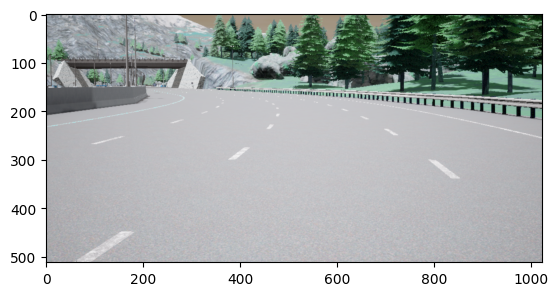

In [4]:
# 데이터 확인해보기
img = plt.imread(os.path.join(data_dir,"tr", tr_imgs[0]))
plt.imshow(img)
plt.show()

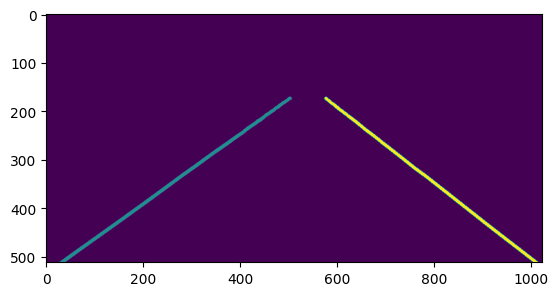

In [5]:
#라벨링 이미지 확인해보기
label_img = os.listdir(train_label)
label_img = plt.imread(os.path.join(data_dir,"tr_lb", label_img[0]))
plt.imshow(label_img)
plt.show()

In [6]:
root_dir = 'data'
train_x = os.path.join(root_dir,'tr')
train_y = os.path.join(root_dir,'tr_lb')

val_x = os.path.join(root_dir,'val')
val_y = os.path.join(root_dir,'val_lb')


In [7]:
# 이미지 plot 함수
def plot_img(**img):
    img_len = len(img)
    
    plt.figure(figsize=(16, 5))
    
    for i, (j, k) in enumerate(img.items()):
        plt.subplot(1, img_len, i + 1)
        
        
        plt.xticks([])
        plt.yticks([])
        
        plt.title(' '.join(j.split('_')).title())
        plt.imshow(k)
    plt.show()

In [8]:
class LaneData(Dataset):
    # 정답 레이블을 나타내는 리스트
    y_class = ['bg','left','right']

    def __init__(self, img_dir, msk_dir, augment=None, y_class=None, preproc=None):
        
        self.img_dir = os.listdir(img_dir)
        
        # 
        self.img_path = [os.path.join(img_dir, img_idx) for img_idx in self.img_dir]
        # 
        get_lb_name = lambda x: re.sub(".png", "_label.png", x)
        # 
        self.msk_path = [os.path.join(msk_dir, get_lb_name(img_idx)) for img_idx in self.img_dir]

        self.augment = augment

        
                        
        self.class_v = [self.y_class.index(cls.lower()) for cls in y_class]

        # 데이터 전처리 설정
        self.preproc = preproc

    def __len__(self):
        # 데이터셋의 샘플 개수 반환
        return len(self.img_dir)

    def __getitem__(self, idx):
        # 이미지와 마스크 데이터를 읽어옴
        img = cv2.imread(self.img_path[idx])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        msk = cv2.imread(self.msk_path[idx], 0)

        if self.augment:
            # 데이터 augmentation 수행
            sample = self.augment(image=img, mask=msk)
            img, msk = sample['image'], sample['mask']

        if self.preproc:
            # 데이터 전처리 수행
            sample = self.preproc(image=img, mask=msk)
            img, msk = sample['image'], sample['mask']

        # 이미지와 마스크를 Tensor 형태로 변환하여 반환
        return img, LongTensor(msk)

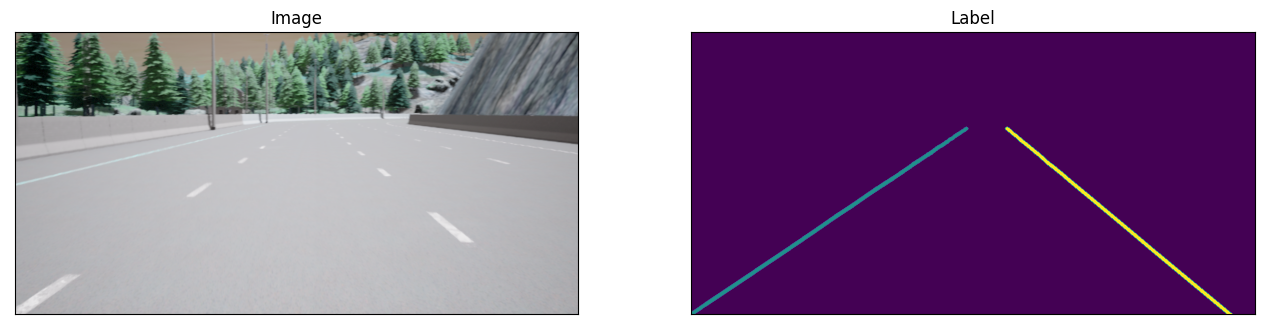

In [9]:
dataset = LaneData(train_x, train_y,y_class=LaneData.y_class)   # LaneData class를 이용해 train_x와 train_y를 활용한 dataset 생성                 

img, msk = dataset[1]                                           # 이미지 plot 해보기위해 dataset의 두번째 인덱스 값을 img와 msk에 저장                                                                   
plot_img(                                                       # img와 msk값을 각각 plot
    image = img, 
    label = msk
)                                                                 

In [10]:
import albumentations as AB

def get_tr_aug():
    tr_tf = [
        AB.ShiftScaleRotate(scale_limit=0.1, rotate_limit=0., shift_limit=0.1, p=1, border_mode=0),     # 이미지의 크기와 위치를 무작위로 변환
        AB.IAAAdditiveGaussianNoise(p=0.2),                                                             # 가우시안 노이즈 추가
        AB.OneOf([
            AB.CLAHE(p=1),                                                                              # 이미지의 대비를 개선
            AB.RandomBrightness(p=1),                                                                   # 이미지의 밝기를 무작위로 변화
            AB.RandomGamma(p=1),                                                                        # 이미지의 감마값을 무작위로 변화
        ], p=0.6),
        AB.OneOf([
            AB.IAASharpen(p=1),                                                                         # 이미지를 날카롭게 만듦
            AB.Blur(blur_limit=3, p=1),                                                                 # 이미지를 블러처리
            AB.MotionBlur(blur_limit=3, p=1),                                                           # 이미지에 모션 블러 효과 추가
        ], p=0.6),
        AB.OneOf([
            AB.RandomContrast(p=1),                                                                     # 이미지의 대비를 무작위로 변화
            AB.HueSaturationValue(p=1),                                                                 # 이미지의 색상과 채도를 무작위로 변화
        ], p=0.6),
    ]
    return AB.Compose(tr_tf)


def get_val_aug():
    return None


def _ToTensor(x, **kwargs):
    pass
    # print(np.shape(x))
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocess(preprocess_fn):   
    _tf = [
        AB.Lambda(image=preprocess_fn),                                                                 # 이미지에 전처리 함수 적용
        AB.Lambda(image=_ToTensor),                                                                     # 이미지를 텐서 형태로 변환
    ]
    return AB.Compose(_tf)


/home/ubuntu/micromamba/envs/py37/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:261: FutureWarning: IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead
  warnings.warn("IAAAdditiveGaussianNoise is deprecated. Please use GaussNoise instead", FutureWarning)
/home/ubuntu/micromamba/envs/py37/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1151: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,
/home/ubuntu/micromamba/envs/py37/lib/python3.7/site-packages/albumentations/imgaug/transforms.py:231: FutureWarning: IAASharpen is deprecated. Please use Sharpen instead
  warnings.warn("IAASharpen is deprecated. Please use Sharpen instead", FutureWarning)
/home/ubuntu/micromamba/envs/py37/lib/python3.7/site-packages/albumentations/augmentations/transforms.py:1177: FutureWarning: RandomContrast has been deprecated. Please use RandomBrightnessContrast
  FutureWarning,


(512, 1024, 3)


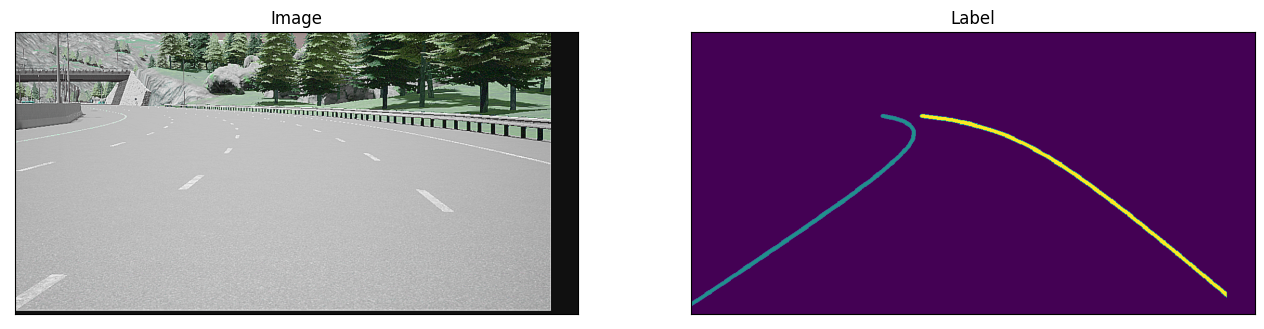

(512, 1024, 3)


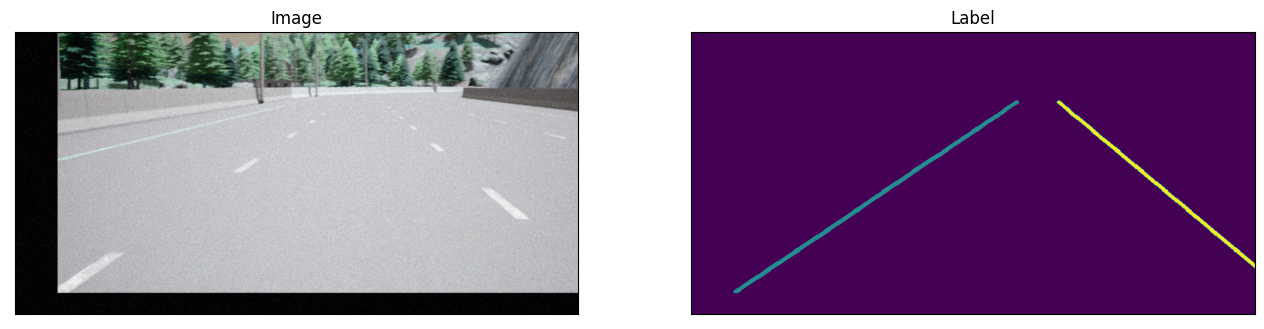

(512, 1024, 3)


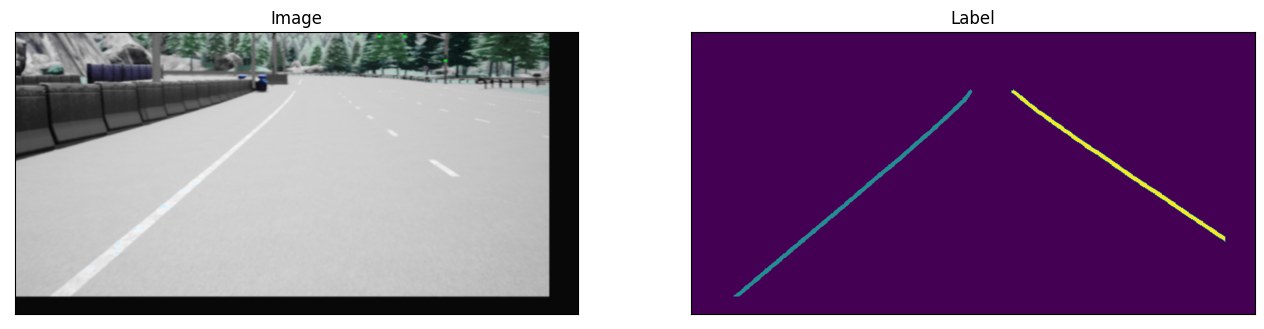

In [11]:
aug_dataset = LaneData(                    
    train_x, 
    train_y, 
    augment=get_tr_aug(), 
    y_class=LaneData.y_class
)

for i in range(3):
    img, msk = aug_dataset[i]
    print(np.shape(img))
    plot_img(image=img, label=msk)

In [12]:
loss_set = 'multi_dice_loss'                                                                # 사용할 loss 함수 설정

encoder = 'efficientnet-b0'                                                                 # 사용할 encoder 모델 설정
encoder_w = 'imagenet'                                                                      # encoder 모델의 가중치 설정
ACTIVATION = 'softmax2d'                                                                    # 활성화 함수 설정
DEVICE = 'cuda'                                                                             # 사용할 디바이스 설정

# pretrained encoder를 사용하여 segmentation model 생성
model = SM.FPN(
    encoder_name=encoder, 
    encoder_weights=encoder_w, 
    classes=len(LaneData.y_class), 
    activation=ACTIVATION,
    #encoder_depth = 4
)

preprocessing_fn = SM.encoders.get_preprocessing_fn(encoder, encoder_w)                     # 전처리 함수 설정


In [13]:
train_dataset = LaneData(                                   # augmentation과 전처리가 들어간 train_dataset 생성
    train_x, 
    train_y, 
    augment=get_tr_aug(), 
    preproc=get_preprocess(preprocessing_fn),
    y_class=LaneData.y_class,
)
valid_dataset = LaneData(                                   # augmentation과 전처리가 들어간 valid_dataset 생성
    val_x, 
    val_y, 
    augment=get_val_aug(), 
    preproc=get_preprocess(preprocessing_fn),
    y_class=LaneData.y_class,
)

In [14]:
batch_tr = 4                                                                                # 학습 데이터 배치 크기 설정
batch_val = 4                                                                               # 검증 데이터 배치 크기 설정

tr_loader = DataLoader(train_dataset, batch_size=batch_tr, shuffle=True)                    # 학습 데이터 로더 생성
val_loader = DataLoader(valid_dataset, batch_size=batch_val, shuffle=False)                 # 검증 데이터 로더 생성


In [15]:
from segmentation_models_pytorch.utils.losses import DiceLoss                                   # Dice Loss를 계산하기 위한 모듈
from segmentation_models_pytorch.utils.metrics import Accuracy                                  # 정확도 측정을 위한 모듈
from segmentation_models_pytorch.utils import base                                              # Segmentation 모델에 사용되는 유틸리티 모듈

label_left = LaneData.y_class.index('left')                                                     # 'left' 클래스의 레이블 인덱스 설정
label_right = LaneData.y_class.index('right')                                                   # 'right' 클래스의 레이블 인덱스 설정

class MultiDiceLoss(base.Loss):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.BinaryDiceLossLeft = DiceLoss()                                                    # 'left' 클래스에 대한 Dice Loss를 계산하기 위한 객체 생성
        self.BinaryDiceLossRight = DiceLoss()                                                   # 'right' 클래스에 대한 Dice Loss를 계산하기 위한 객체 생성
        
    def forward(self, y_pr, y_gt):
        #print("shape y_pr:", y_pr.shape)
        #print("shape y_gt:", y_gt.shape)
        # ypr.shape=bs,3,512,1024, ygt.shape=bs,512,1024
        left_gt = (y_gt == label_left)                                                          # 'left' 클래스에 해당하는 ground truth 생성
        right_gt = (y_gt == label_right)                                                        # 'right' 클래스에 해당하는 ground truth 생성
        loss_left = self.BinaryDiceLossLeft.forward(y_pr[:, label_left, :, :], left_gt)         # 'left' 클래스에 대한 Dice Loss 계산
        loss_right = self.BinaryDiceLossRight.forward(y_pr[:, label_right, :, :], right_gt)     # 'right' 클래스에 대한 Dice Loss 계산
        return (loss_left + loss_right) * 0.5                                                   # 두 클래스의 Loss의 평균 반환


In [16]:
metrics = []                                                        # 사용할 메트릭스 리스트
loss = MultiDiceLoss()                                              # 정의한 MultiDiceLoss 객체를 loss로 설정
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-4)    # Adam 옵티마이저를 생성하고 모델의 파라미터와 학습률을 설정하여 초기화

train_epoch = SM.utils.train.TrainEpoch(
    model,                                                          # 학습할 모델
    loss=loss,                                                      # 사용할 손실 함수 (MultiDiceLoss)
    metrics=metrics,                                                # 사용할 메트릭스 리스트
    optimizer=optimizer,                                            # 사용할 옵티마이저 (Adam)
    device=DEVICE,                                                  # 사용할 디바이스 (cuda)
    verbose=True,                                                   # 학습 과정에서 로그를 출력할지 여부
)

valid_epoch = SM.utils.train.ValidEpoch(
    model,                                                          # 평가할 모델
    loss=loss,                                                      # 사용할 손실 함수 (MultiDiceLoss)
    metrics=metrics,                                                # 사용할 메트릭스 리스트
    device=DEVICE,                                                  # 사용할 디바이스 (cuda)
    verbose=True,                                                   # 평가 과정에서 로그를 출력할지 여부
)


In [17]:
best_loss = 1e10                                                    # 최적의 손실값을 저장할 변수 초기화

for i in range(0, 5):                                               # 5번의 에포크 동안 반복

    print('\nEpoch: {}'.format(i))                                  # 현재 에포크 번호 출력
    train_logs = train_epoch.run(tr_loader)                         # 학습 과정 실행 및 로그 저장
    valid_logs = valid_epoch.run(val_loader)                        # 평가 과정 실행 및 로그 저장

    if best_loss > valid_logs[loss_set]:                            # 현재 손실값이 최적의 손실값보다 작은 경우
        best_loss = valid_logs[loss_set]                            # 최적의 손실값 업데이트
        torch.save(model, './best_model_{}.pth'.format(loss_set))   # 모델 저장
        print('Model saved!')
        
    if i == 3:                                                      # 3번째 에포크에서
        optimizer.param_groups[0]['lr'] = 1e-5                      # 디코더의 학습률을 1e-5로 감소
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
valid: 100%|██████████| 33/33 [00:20<00:00,  1.60it/s, multi_dice_loss - 0.2024]
Model saved!

Epoch: 1
valid: 100%|██████████| 33/33 [00:19<00:00,  1.67it/s, multi_dice_loss - 0.1388]
Model saved!

Epoch: 2
valid: 100%|██████████| 33/33 [00:18<00:00,  1.75it/s, multi_dice_loss - 0.1263]
Model saved!

Epoch: 3
valid: 100%|██████████| 33/33 [00:18<00:00,  1.81it/s, multi_dice_loss - 0.1207]
Model saved!
Decrease decoder learning rate to 1e-5!

Epoch: 4
valid: 100%|██████████| 33/33 [00:19<00:00,  1.67it/s, multi_dice_loss - 0.1083]
Model saved!


In [17]:
best_model = torch.load('./best_model_multi_dice_loss.pth')         # 저장된 최적 모델을 불러옵니다.

test_best_model = True                                              # 최적 모델을 테스트할지 여부를 설정합니다.
if test_best_model:
    test_dataset = LaneData(                                        # 테스트 데이터셋을 생성합니다.
        val_x, 
        val_y, 
        augment=get_val_aug(), 
        preproc=get_preprocess(preprocessing_fn),
        y_class=LaneData.y_class,
    )

    test_dataloader = DataLoader(test_dataset)                      # 테스트 데이터로더를 생성합니다.

    test_epoch = SM.utils.train.ValidEpoch(                         # 테스트를 위한 ValidEpoch 객체를 생성합니다.
        model=best_model,
        loss=loss,
        metrics=metrics,
        device=DEVICE,
    )

    logs = test_epoch.run(test_dataloader) 


valid: 100%|██████████| 129/129 [00:10<00:00, 12.88it/s, multi_dice_loss - 0.1054]


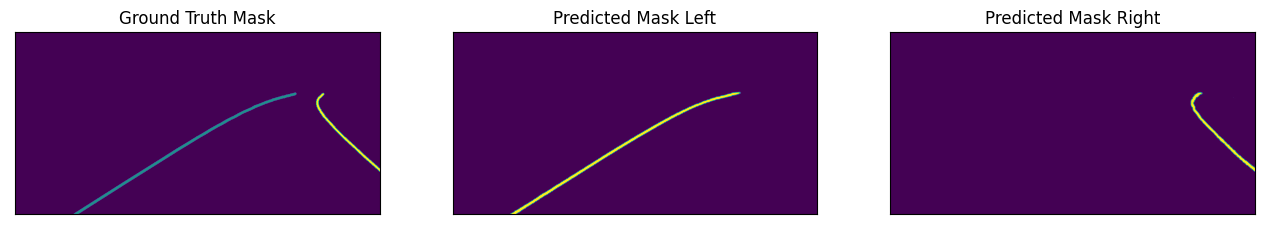

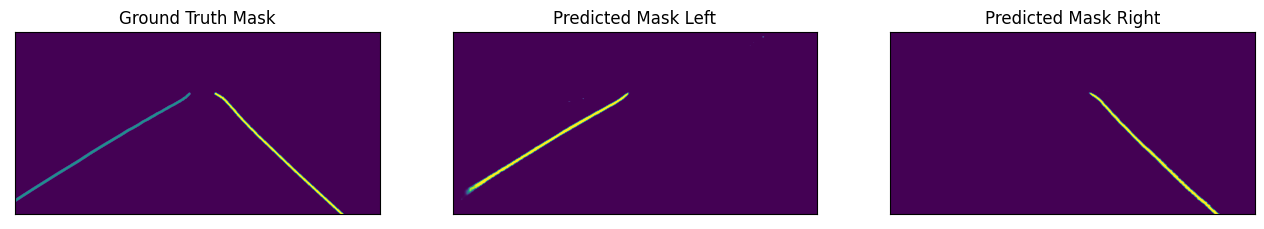

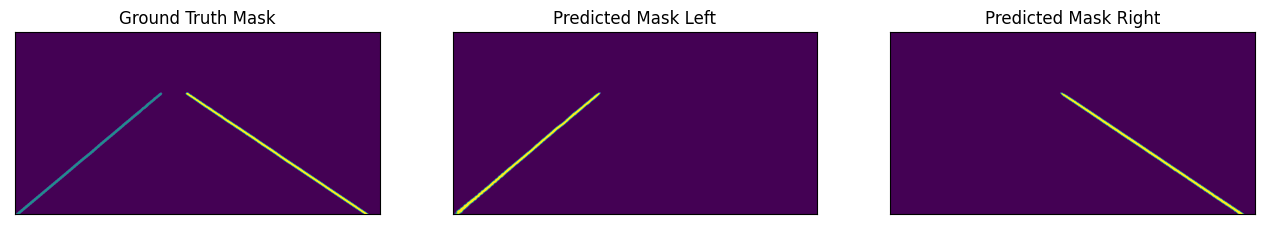

In [23]:
test_dataset_vis = LaneData(
    val_x, val_y, 
    y_class=LaneData.y_class,
    preproc=get_preprocess(preprocessing_fn)
)
    
for i in range(3):
    n = np.random.choice(len(test_dataset_vis))

    # 시각화할 이미지와 ground truth 마스크 가져오기
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = test_dataset_vis[n]

    # 입력 이미지를 텐서로 변환하고 모델로부터 예측된 마스크 가져오기
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask_left = best_model.predict(x_tensor)[0, 1, :, :]
    pr_mask_left = pr_mask_left.cpu().numpy()

    pr_mask_right = best_model.predict(x_tensor)[0, 2, :, :]
    pr_mask_right = pr_mask_right.cpu().numpy()

    # 이미지와 예측된 마스크 시각화
    plot_img(
        ground_truth_mask=gt_mask,              # GT값 마스크
        predicted_mask_left=pr_mask_left,       # 왼쪽 예측 마스크
        predicted_mask_right=pr_mask_right      # 오른쪽 예측 마스크
    )